In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(r"C:\Users\kishan\Downloads\archive (1)\training.1600000.processed.noemoticon.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
29416,0,1563471268,Sun Apr 19 22:58:02 PDT 2009,NO_QUERY,scorpfromhell,@_Anshul no it happens every year #India #Ori...
1398322,4,2054085832,Sat Jun 06 06:31:13 PDT 2009,NO_QUERY,Lucy0rLulu,"is babysitting for the whole day, not doing so..."
1513525,4,2175363682,Mon Jun 15 00:46:52 PDT 2009,NO_QUERY,murz13,This is my 2900th tweet! Dedicated to @Jonasbr...
359241,0,2045681214,Fri Jun 05 11:04:52 PDT 2009,NO_QUERY,alexis3m,Feel horrible! alcohol just spoiled my big day...
131531,0,1835553479,Mon May 18 06:15:06 PDT 2009,NO_QUERY,c_benz,where did all the warm weatherrr gooo?


In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
print('length of data is', len(df))

length of data is 1600000


In [6]:
df.shape

(1600000, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [9]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [10]:
df['target'].nunique()

2

In [11]:
df['target'].unique()

array([0, 4], dtype=int64)

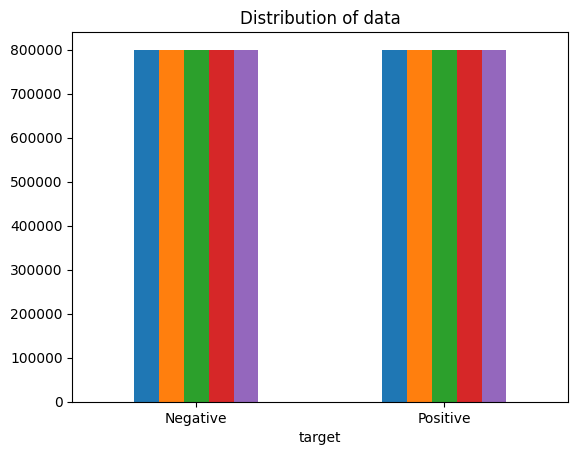

In [12]:

ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

text, sentiment = list(df['text']), list(df['target'])

In [13]:
data=df[['text','target']]

In [14]:
data['target'] = data['target'].replace(4,1)

C:\Users\kishan\AppData\Local\Temp\ipykernel_12764\2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [15]:
data['target'].unique()

array([0, 1], dtype=int64)

In [16]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [17]:
data_pos = data_pos.iloc[:int(800000)]
data_neg = data_neg.iloc[:int(800000)]

In [18]:
dataset = pd.concat([data_pos, data_neg])

In [19]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

In [20]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [21]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [22]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [23]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [24]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [25]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [26]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [31]:
X=data.text
y=data.target

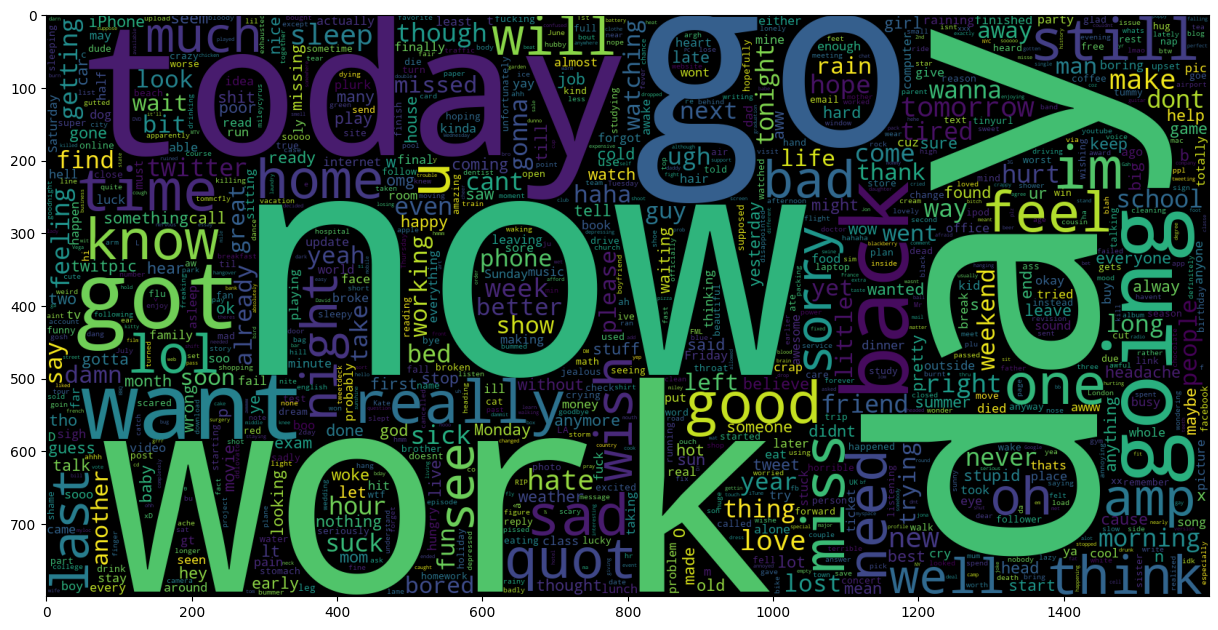

In [33]:
data_neg = data['text'][:800000]
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

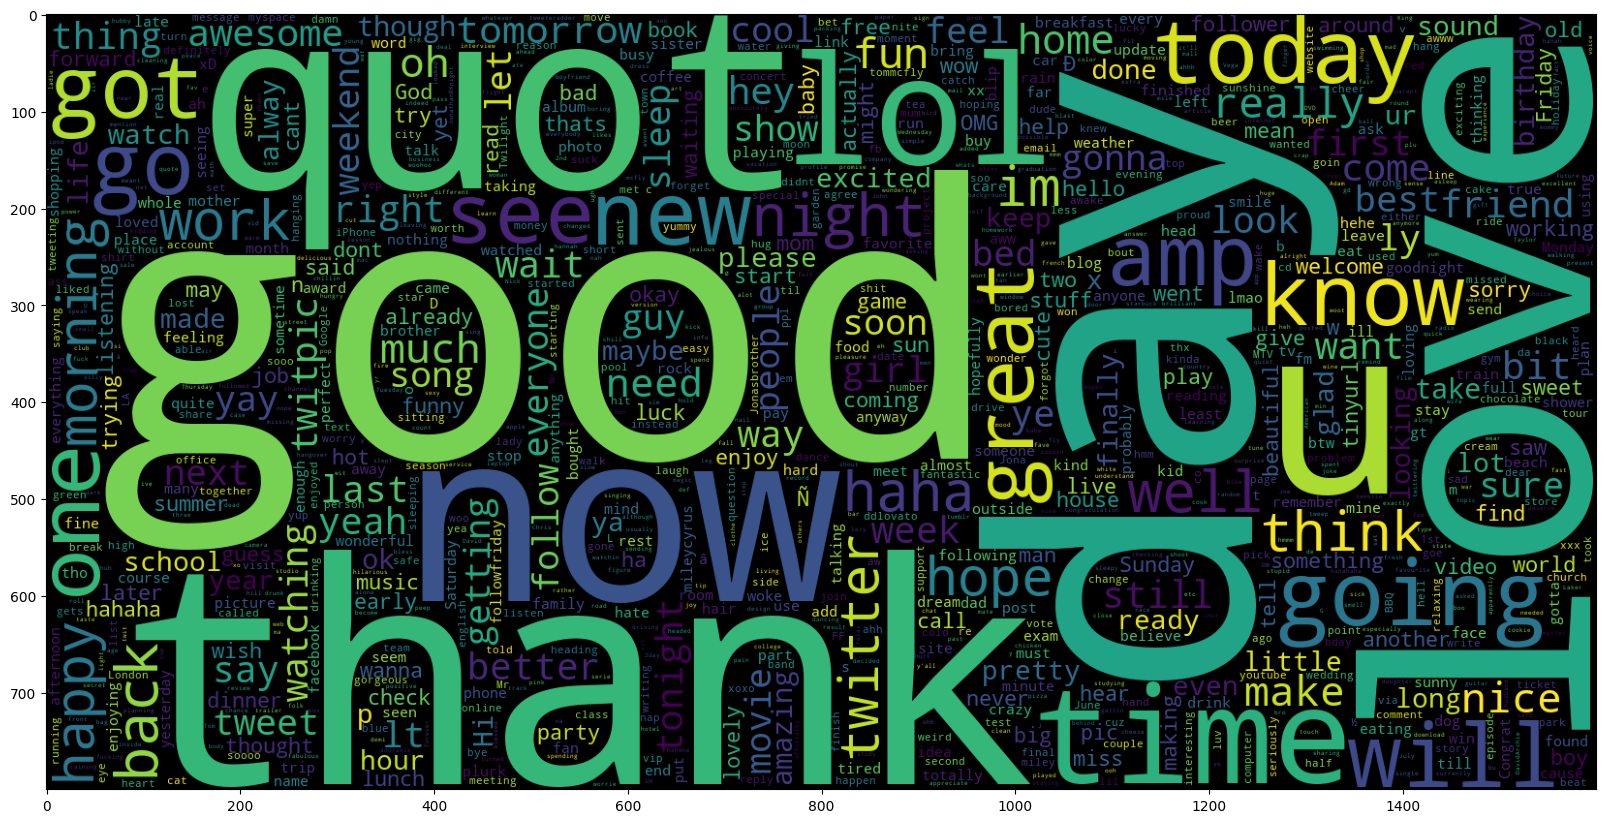

In [34]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)

X_train_tfidf = vectoriser.fit_transform(X_train)

feature_names = vectoriser.get_feature_names_out()

print('No. of feature_words: ', len(feature_names))

No. of feature_words:  500000


In [38]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [40]:
def model_Evaluate(model):
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


C:\Users\kishan\anaconda3\envs\python_3_11_3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



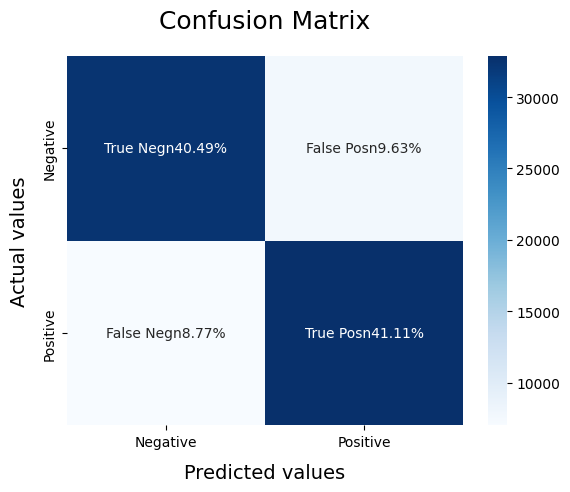

In [41]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

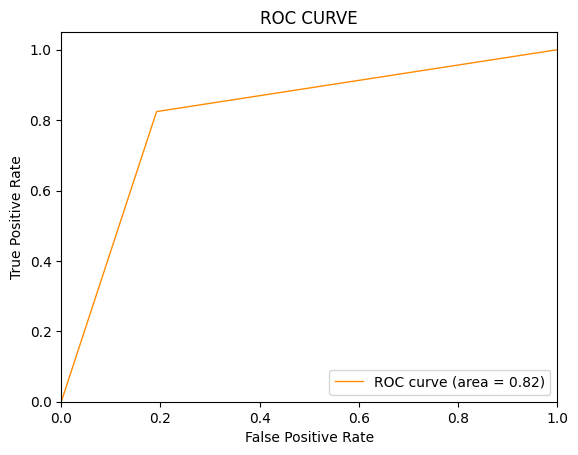

In [42]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



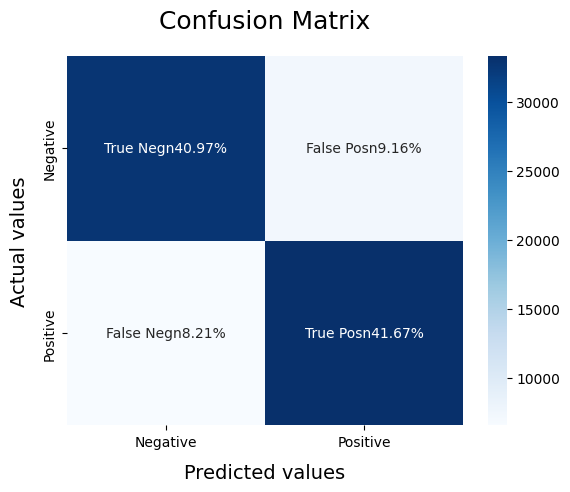

In [43]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

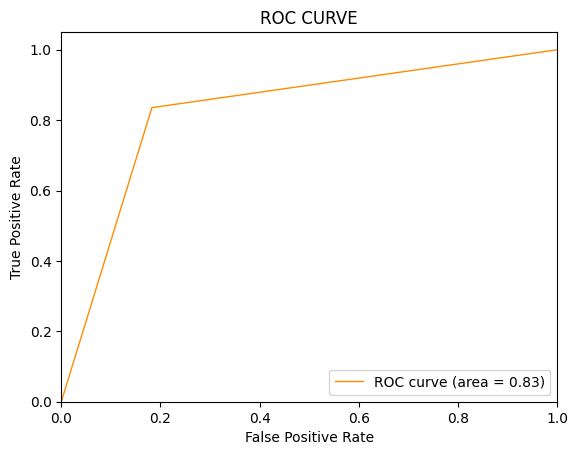

In [44]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()